In [1]:
from detector import predict
import torch
import numpy as np
import os
import os.path as osp
from postprocess import postprocess
from args import arg_parse
from __future__ import division
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2
from util import *
import os
import os.path as osp
from darknet import Darknet
from preprocess import prep_image, inp_to_image
import pandas as pd
import random
import pickle as pkl
import itertools
from PIL import Image

import sys
sys.path.append("../darknet")

In [2]:
class Args:
    def __init__(self):
        self.bs = 1
        self.confidence = .5
        self.cfgfile = "cfg/yolov3.cfg"
        self.nms_thresh = .4
        self.weightsfile = "yolov3.weights"
        self.images = None
        self.reso = "416"
        self.scales = "1,2,3"
        self.saveto = ""
        self.silent = None
        self.cuda = "3"
        self.det = "det"
        self.vot = "/home/zabulskyy/data/vot2016/"
        self.pp = "first_and_mfc_smart"
        self.saveto = "lol.txt"

In [3]:
def fill_zeros(folder):
    return [[0, 0, 0, 0] for i in os.listdir(folder) if i.endswith(".jpg")]

In [4]:
def print_tensor(tensor):
    for row in tensor.int():
        print()
        for cell in row:
            print("{0}   ".format(cell), end="")
        print()
        

In [5]:
def print_pred(impath, prediction):
    im = Image.open(im_path)
    plt.imshow(im)
    plt.title(impath.split('/')[-1])
    for pr_bb in prediction[:, 1:5]:
        X, Y = pr_bb[::2], pr_bb[1::2]
        pr_bb = [min(X), min(Y), max(X),  max(Y)]
        plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                             [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)

In [11]:
args = Args()
vot_path = args.vot
saveto = args.saveto
# pp = None if args.pp.lower() == "none" else args.pp

cuda_n = int(args.cuda)
silent = args.silent == "all"
if (silent):
    import sys
    sys.stdout = open(os.devnull, 'w')
batch_size = int(args.bs)
confidence = float(args.confidence)
nms_thesh = float(args.nms_thresh)
start = 0

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda

CUDA = torch.cuda.is_available()

classes = load_classes('data/coco.names')
num_classes = len(classes)

# Set up the neural network
print("Loading network.....")
model = Darknet(args.cfgfile)
model.load_weights(args.weightsfile)
print("Network successfully loaded")

model.net_info["height"] = args.reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0
assert inp_dim > 32

# If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()

# Set the model in evaluation mode
model.eval()
print()
# Detection phase

vot_path = args.vot
saveto = args.saveto

folder = "bmx"

result = dict()
num_frames = dict()

images = osp.join(vot_path, folder)
if (not os.path.isdir(images)):
    print(folder, "is not a folder")
    exit()

print("processing {}".format(folder))

try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in sorted(
        os.listdir(images))[:] if os.path.splitext(
        img)[1] == '.png' or os.path.splitext(
        img)[1] == '.jpeg' or os.path.splitext(img)[1] == '.jpg']
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print("No file or directory with the name {}".format(images))
    exit()

num_frames[folder] = len(imlist)

batches = list(
    map(prep_image, imlist, [inp_dim for x in range(len(imlist))]))
im_batches = [x[0] for x in batches]
orig_ims = [x[1] for x in batches]

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover
    im_batches = [torch.cat((
        im_batches[i*batch_size: min((i + 1)*batch_size,
        len(im_batches))])) for i in range(num_batches)]
    

In [30]:
imlist

['/home/zabulskyy/data/vot2016/bmx/00000001.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000002.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000003.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000004.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000005.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000006.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000007.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000008.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000009.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000010.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000011.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000012.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000013.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000014.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000015.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000016.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000017.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000018.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000019.jpg',
 '/home/zabulskyy/data/vot2016/bmx/00000020.jpg',


/home/zabulskyy/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


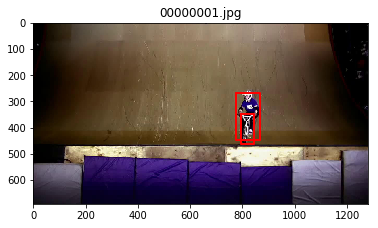

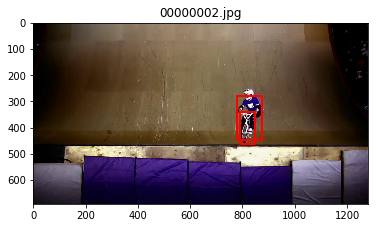

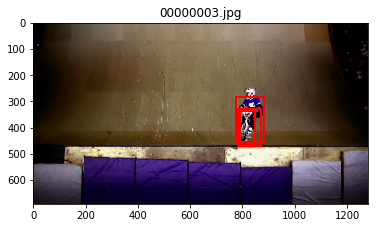

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [12]:
i = 0
for batch in im_batches:

    '''=====detection pahse====='''
    
    if CUDA:
        batch = batch.cuda()

    with torch.no_grad():
        prediction = model(Variable(batch), CUDA)

    prediction = write_results(
        prediction, confidence, num_classes, nms=True, nms_conf=nms_thesh)

    if type(prediction) == int:
        i += 1
        continue
    
    prediction[:, 0] += i*batch_size

    for im_num, image in enumerate(imlist[i*batch_size: min((i + 1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in prediction if int(x[0]) == im_id]
    
    i += 1

    if CUDA:
        torch.cuda.synchronize()
        
    im_dim_list = [x[2] for x in batches]
    im_dim_list = torch.FloatTensor(im_dim_list).repeat(1, 2)

    if CUDA:
        im_dim_list = im_dim_list.cuda()

    im_dim_list = torch.index_select(im_dim_list, 0, prediction[:, 0].long())
    scaling_factor = torch.min(inp_dim/im_dim_list, 1)[0].view(-1, 1)
    prediction[:, [1, 3]] -= (inp_dim - scaling_factor * im_dim_list[:, 0].view(-1, 1)) / 2
    prediction[:, [2, 4]] -= (inp_dim - scaling_factor * im_dim_list[:, 1].view(-1, 1)) / 2
    prediction[:, 1:5] /= scaling_factor

    for j in range(prediction.shape[0]):
        prediction[j, [1, 3]] = torch.clamp(
            prediction[j, [1, 3]], 0.0, im_dim_list[j, 0])
        prediction[j, [2, 4]] = torch.clamp(
            prediction[j, [2, 4]], 0.0, im_dim_list[j, 1])
    
    '''=====plotting====='''
        
    im = Image.open(image)
    plt.imshow(im)
    plt.title(image.split('/')[-1])
    for pr_bb in prediction[:, 1:5]:
        X, Y = pr_bb[::2], pr_bb[1::2]
        pr_bb = [min(X), min(Y), max(X),  max(Y)]
        plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                             [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)
    plt.show()
    plt.clf()
    

In [29]:
len(batches[0])    #76 3 1 3 416 416

3

In [14]:
print_tensor(prediction.int())


6   774   243   907   462   0   0   0   

6   768   298   870   459   0   0   1   


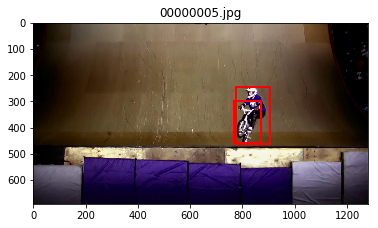

In [15]:
im_path = "/home/zabulskyy/data/vot2016/bmx/00000005.jpg"
print_pred(im_path, prediction)